In [2]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import LSTM # new! 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

In [3]:
# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 100 # lowered due to vanishing gradient over time
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# LSTM layer architecture:
n_lstm = 256 
drop_lstm = 0.2

In [4]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17473536/17464789 [==============================] - 0s 0us/step


In [5]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [6]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(LSTM(n_lstm, dropout=drop_lstm))
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               328704    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 968,961
Trainable params: 968,961
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath="/weights.{epoch:02d}.hdf5")

In [10]:
# go have a gander at nvidia-smi
# 85.2% validation accuracy in epoch 2
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 229s 1s/step - loss: 0.6147 - accuracy: 0.6375 - val_loss: 0.3588 - val_accuracy: 0.8432
Epoch 2/4
196/196 [==============================] - 209s 1s/step - loss: 0.2980 - accuracy: 0.8755 - val_loss: 0.3530 - val_accuracy: 0.8424
Epoch 3/4
196/196 [==============================] - 209s 1s/step - loss: 0.2365 - accuracy: 0.9097 - val_loss: 0.3670 - val_accuracy: 0.8422
Epoch 4/4
196/196 [==============================] - 207s 1s/step - loss: 0.1879 - accuracy: 0.9321 - val_loss: 0.3652 - val_accuracy: 0.8440


In [12]:
model.load_weights("/weights.04.hdf5") # zero-indexed

In [13]:
y_hat = model.predict_proba(x_valid)

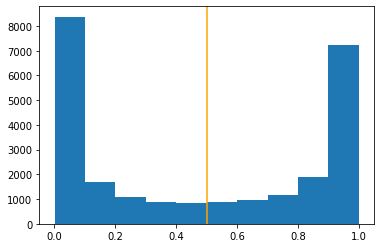

In [14]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [15]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'92.34'